In [1]:
from collections import deque
import time, sys
import numpy as np
import matplotlib.pyplot as plt
from utils import printProgressBar

import numba
from numba import jit
from numba import objmode
from numba import jitclass          # import the decorator
from numba import int32, float64    # import the types



Nexc = 250         # number of excitatory neurons in the network
Ninh = 50          # number of inhibitory neurons in the network
T = 800            # simulation time, ms
H = 0.01           # dt, ms
stimStart = 200.0
stimStop = 600.0
times = np.round(np.arange(0, T, H), 2)

def initw(size, prob):
    arr = np.zeros((size[0]*size[1], ))
    arr[:int(prob*size[0]*size[1])] = 1
    np.random.shuffle(arr)
    arr = arr.reshape(size[0], size[1])
    return arr

c_EE = initw(size=(Nexc,Nexc), prob=0.2)
c_IE = initw(size=(Ninh,Nexc), prob=0.2) 
c_EI = initw(size=(Nexc,Ninh), prob=0.5) 
c_II = initw(size=(Ninh,Ninh), prob=0.5) 

Time = time.time()
d = deque(maxlen=5)
d.append(np.nan)

def bar(step, steps):
    global d
    d.append(time.time())
    meanTimePerCycle = np.mean(np.diff(d))
    remains = steps - step
    cycles = remains/400
    eta = cycles * meanTimePerCycle
    if not np.isnan(eta):
        ETA = "ETA: {:.2f} s.".format(eta)
    else:
        ETA = "ETA: calculating..."
    printProgressBar(step, steps, suffix=ETA, length = 50)

@jit(nopython=True, fastmath=True)
def run(Nexc, Ninh, T, times, H, stimStart, stimStop, c_EE, c_IE, c_EI, c_II):
    
    t_Eud = 5.0        # average time that an excitatory neuron's state is updated 
    t_Iud = 2.5        # average time that an inhibitory neuron's state is updated

    step = 0

    out_E = np.zeros((Nexc, len(times)))
    out_I = np.zeros((Ninh, len(times)))
    y_t = np.zeros((Nexc, len(times)))
    
    # thresholds of update
    h_E = 1.0
    h_I = 1.0
    
    # amplitude of steady external input
    I_Eex = 2.0
    I_Iex = 0.5
    
    I_p = np.zeros((Nexc, ))
    
    m_ex = 0.3
    sigma_ex = 0.1
    
    # average update time of neurons, /s
    t_Eud = 5.0 # excitatory
    t_Iud = 2.5 # inhibitory
    Cp = 0.01875
    Cd = 0.0075

    tauP = 20 #20/H # ms/dt
    tauD = 40 # 40/H # ms/dt
    
    tau_sd = 600.0
    u_sd = 0.3       # try a different value!!!
    
    tauh = 100000.0 # !!!!!!!!!!!!!!!!!!!!!
    sigmah = 0.00015

    y = np.ones((Nexc, )) * 0.2
    Y = 0
    X = 0
    st_neur = int(Nexc*0.8)
    
    J_EE = 0.3 * np.random.randn(Nexc,Nexc) + 0.18
    for post in range(Nexc):
        for pre in range(Nexc):
            if J_EE[post, pre] < 0.0:
                J_EE[post, pre] = 0.0
            if J_EE[post, pre] > 0.75:
                J_EE[post, pre] = 0.75

    J_EI = np.ones((Nexc, Ninh)) * 0.15
    J_II = np.ones((Ninh, Ninh)) * 0.06
    J_IE = np.ones((Ninh, Nexc)) * 0.15

    x_E = np.zeros((Nexc, ))
    x_I = np.zeros((Ninh, ))
    lastSpikeTime = np.ones((Nexc, )) * -5e7
    alpha = 50.0
    JEE = 0.15


    for t in times:
        Iex_ud = np.arange(0, Nexc, 1)
        Iinh_ud = np.arange(0, Ninh, 1)
        if t == stimStart:
            print('yeah')
            I_p[st_neur:] = 1
        if t == stimStop:
            print('oh')
            I_p = np.zeros((Nexc, ))

        for i in Iex_ud: #range(Nexc):
            xi_E = np.random.randn()
            acc = 0.0
            for j in range(Nexc):
                if j!=i:
                    acc += c_EE[i,j] * J_EE[i,j] * y[j] * x_E[j]
            for j in range(Ninh):
                acc -= c_EI[i,j] * J_EI[i,j] * x_I[j]  
            acc += I_Eex * (m_ex + sigma_ex * xi_E) + I_p[i] - h_E
            x_E[i] = 1 if acc > 0 else 0
        
        """updated STP"""
        for j in Iex_ud:           
            y[j] += ((1-y[j])/tau_sd - u_sd*y[j] * x_E[j])*H
        
        for i in Iinh_ud: #range(Ninh):
            xi_I = np.random.randn()
            acc = 0.0
            for j in range(Nexc):
                acc += c_IE[i,j] * J_IE[i,j] * x_E[j]
            for j in Iinh_ud: #range(Ninh):
                if j!=i:
                    acc -= c_II[i,j] * J_II[i,j] * x_I[j]
            acc += I_Iex * (m_ex + sigma_ex * xi_I) - h_I
            x_I[i] = 1 if acc > 0 else 0
        
        
        """STDP"""
        for post in Iex_ud:
            if x_E[post] == 1:
                lastSpikeTime[post] = t
            Y = Cd * np.exp(-(t-lastSpikeTime[post])/tauD)  # fix tau and Fd !!!! (Log-STDP!!!!)

            for pre in Iex_ud:
                if x_E[pre] == 1:
                    lastSpikeTime[pre] = t
                X = Cp * np.exp(-(t-lastSpikeTime[pre])/tauP) # fix tau!!!!

#                 fd = np.log(1 + alpha * J_EE[post, pre]/JEE)/np.log(1 + alpha)

                dw = X * x_E[post] - Y * x_E[pre] # f_d(post, pre) # fd * 
                J_EE[post, pre] += dw * c_EE[post, pre]
                
                # homeostatic plasticity
                J_EE[post, pre] += (JEE - J_EE[post,pre])/tauh + sigmah * np.random.randn()

                # clip the the weights:
                if J_EE[post, pre] < 0.0:
                    J_EE[post, pre] = 0.0
                if J_EE[post, pre] > 0.75:
                    J_EE[post, pre] = 0.75
                
        out_E[:,step] = x_E
        out_I[:,step] = x_I
        y_t[:,step] = y
        step += 1
        if step%400==0:
            with objmode():
                bar(step, len(times))
    return out_E, out_I, J_EE, y_t

out_E, out_I, J_EE, y_t = run(Nexc, Ninh, T, times, H, stimStart, stimStop, c_EE, c_IE, c_EI, c_II)

print(time.time()-Time)


 |█-------------------------------------------------| 3.0% ETA: 194.92 s.ng...

KeyboardInterrupt: 

Text(0, 0.5, 'Spike count')

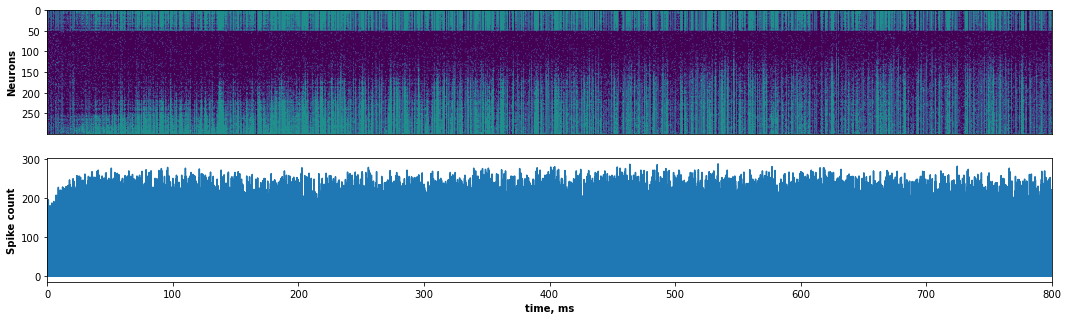

In [3]:
out = np.vstack((out_I, out_E))

plt.figure(figsize=(18,5))
plt.subplot(2,1,1)
plt.imshow(out, aspect='auto')
plt.xlim(0, 3000)
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('Neurons', weight='bold')
plt.subplot(2,1,2)
plt.plot(times, np.sum(out, axis=0))
plt.xlim(0, T)
plt.xlabel('time, ms', weight='bold')
plt.ylabel('Spike count', weight='bold')

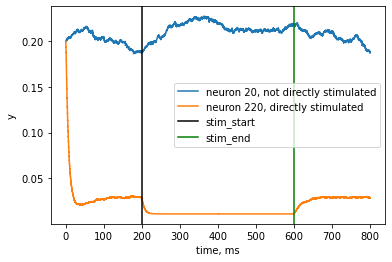

In [4]:
plt.plot(times, y_t[20,:], label='neuron 20, not directly stimulated')
plt.plot(times, y_t[220,:], label='neuron 220, directly stimulated')
plt.xlabel('time, ms')
plt.ylabel('y')

plt.axvline(200, c='k', label='stim_start')
plt.axvline(600, c='g', label='stim_end')
plt.legend()

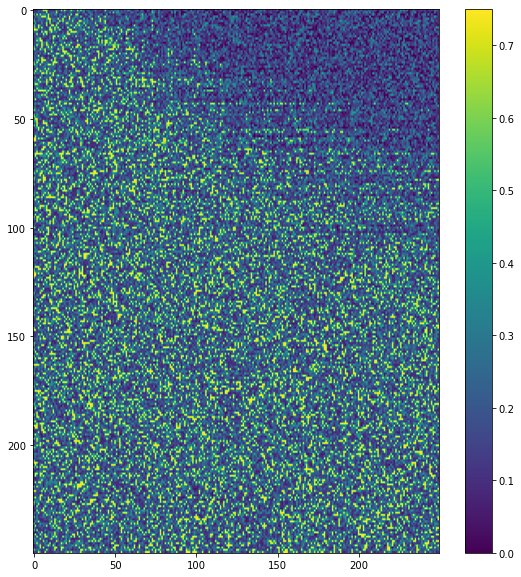

In [5]:
plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.imshow(init_J_EE, aspect='auto')
# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(J_EE, aspect='auto')
plt.colorbar()

In [ ]:
# ca-to-ca
np.mean(J_EE[200:, 200:])

In [ ]:
# bg-to-bg
np.mean(J_EE[:200, :200])

In [ ]:
# ca-to-bg
np.mean(J_EE[:200, 200:])

In [ ]:
# bg-to-ca
np.mean(J_EE[200:, :200])

In [ ]:
color = ['blue', 'red', 'green']
post = 24
pre = [0, 13, 19]

plt.figure(figsize=(18,5))
for i, c in zip(pre, color):
    plt.plot(out_E[i,:]+2, label='Spikes at presyn {}'.format(i), c=c)

plt.plot(out_E[post,:], label='Spikes at Postsyn {}'.format(post))
# plt.plot(net.Y[post,:]*200, label='Trace Postsyn {}'.format(post))
plt.grid()
# plt.plot(net.X[pre,:]*200, label='Trace Presyn {}'.format(pre))
for i, c in zip(pre, color):
    plt.plot(net.W[post,i,:]*10, label='Weight from {} to {}'.format(i, post), c=c)
plt.legend(fontsize=14, loc='right')


plt.figure(figsize=(18,5))

for i, c in zip(pre, color):
    plt.plot(net.X[i,:], label='Traces at presyn {}'.format(i), c=c)
plt.plot(net.Y[post,:], label='Trace Postsyn {}'.format(post))

plt.grid()
plt.legend(fontsize=14, loc='right')

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(net.c_EE)
plt.ylabel('post', weight='bold')
plt.xlabel('pre', weight='bold')
plt.subplot(1,3,2)
plt.imshow(net.J_EE)
plt.ylabel('post', weight='bold')
plt.xlabel('pre', weight='bold')
plt.colorbar()
plt.subplot(1,3,3)
plt.hist(net.J_EE.flatten())
print(net.c_EE[0,12])

<script type="text/javascript" src="https://www.oil-price.net/COMMODITIES/gen.php?lang=en"> </script>
<noscript> To get <a href="http://www.oil-price.net/dashboard.php?lang=en#COMMODITIES">gold, oil and commodity prices</a>, please enable Javascript.</noscript>	


In [ ]:
for(int i = 0; i < NE; i++){
    k1 = (1.0 - ys[i])/trec; 				// trec = 600 (tau_sd)
    k2 = (1.0 - (ys[i]+0.5*hsd*k1))/trec;  	// hsd = 0.1
    k3 = (1.0 - (ys[i]+0.5*hsd*k2))/trec; 
    k4 = (1.0 - (ys[i]+hsd*k3))/trec;
    ys[i] += hsd*(k1 + 2.0*k2 + 2.0*k3 + k4)/6.0;
}

In the paper, short-term plasticity is caluculated accroding to equation (6):


$$
k_1 = \frac{1-y}{\tau_h}
$$

$$
k_2 = \frac{1-y+0.5 h_{sd} k_1}{\tau_h}
$$

$$
k_3 = \frac{1-y+0.5 h_{sd} k_2}{\tau_h}
$$

$$
k_4 = \frac{1 - y + h_{sd} k_3}{\tau_h}
$$

$$
y \leftarrow  \frac {h_{sd} (k_1 + 2 k_2 + 2 k_3 + k_4)}{6}
$$


whereas in the c++ code that I got from the lab server (and hopefully understood correctly) the short-term plasticity is calculated using very different equations. $h_{sd}$ according to the c++ code equals 0.1.

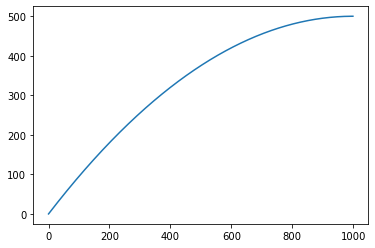

In [17]:
import matplotlib.pyplot as plt

Ip = 1.0
u = -0.625

t2 = 16000
tdur = 1000

U = []
for t in range(t2, t2+tdur):
    u += Ip*(t2+tdur - t)/tdur;
    U.append(u)

plt.plot(U)

In [2]:
with open('/Users/romankoshkin/Downloads/binary_model_r_al50_u10_i150_a90_b30_k0.txt', 'r') as f:
    a = f.readlines()
A = []
for line in a:
    A.append(line.split(' '))
grouped = {}
for time, idx in A:
    grouped.setdefault(float(time), []).append(int(idx))

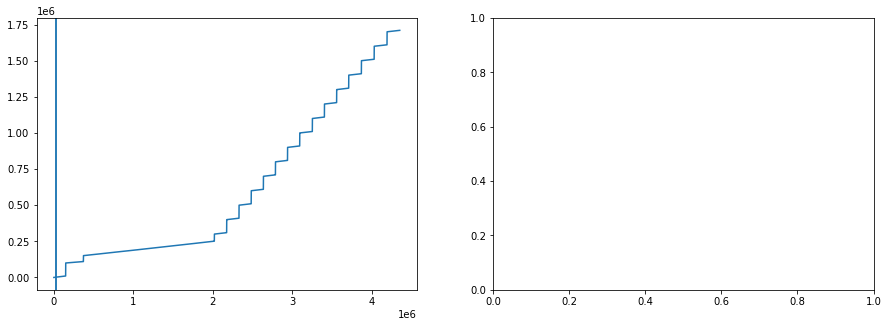

In [56]:
%matplotlib inline
t0, t1 = 31000, 33000

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(list(grouped.keys()))
plt.axvline(t0)
plt.axvline(t1)

plt.subplot(1,2,2)
for t in grouped.keys():
    if (t0 < t ) & (t < t1):
        plt.plot(t * np.ones(len(grouped[t])), grouped[t], '.', c='b')

plt.show()